# Imports

In [1]:
import os
import sys
import json
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

In [3]:
# go up until we are in the project base directory
base_dir = os.getcwd()
while base_dir.split('/')[-1] != 'provide':
    base_dir = os.path.normpath(os.path.join(base_dir, '..'))

# add paths for tools and data
things_to_add = ['aggregation_tools']
for thing in things_to_add:
    sys.path.append(os.path.join(base_dir, thing))

# import stuff we need
from aggregation_preprocessing import assign_rgi_ids_to_target_shapes

# Open data

In [4]:
general_data_dir = os.path.join(base_dir, 'general_data_for_aggregation')
countries_data_dir = os.path.join(base_dir, 'countries', 'data')

In [5]:
# this list is already cleaned from connectivity 2, RGI19 and only common running glaciers
fp_rgi_result_batch = "rgi_ids_to_result_batch.json"
with open(os.path.join(general_data_dir, fp_rgi_result_batch), 'r') as f:
    dict_rgis_to_batch = json.load(f)

In [6]:
df_rgi = pd.read_csv(os.path.join(general_data_dir, 'rgi_position_terminus_backdrop_centroid.csv'),
                     index_col=0)
# only keep rgi_ids which are assigned to a result file
# (excluding connectivity 2 and RGI19, in future also only commonly running glaciers)
df_rgi = df_rgi.loc[list(dict_rgis_to_batch.keys())]
df_rgi['geometry'] = df_rgi.apply(lambda row: Point(row['position_lon'], row['position_lat']), axis=1)
gdf_rgi_ids = gpd.GeoDataFrame(df_rgi, geometry='geometry', crs='EPSG:4326')

In [8]:
countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
gdf_countries = gpd.read_file(os.path.join(countries_data_dir, countries_file))
name_col_countries = 'ADM0_A3_DE'

# Assign common running rgi_ids to countries

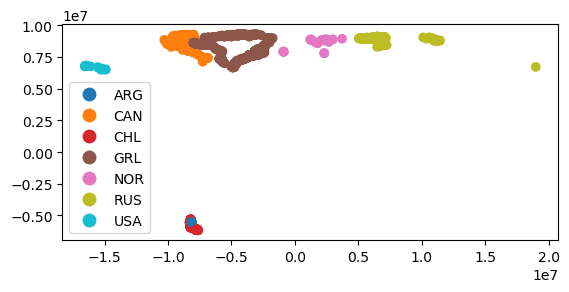

In [7]:
dict_country_to_rgi_ids = assign_rgi_ids_to_target_shapes(
    gdf_rgi_ids, gdf_countries, name_col_countries, do_plot=True)

with open(os.path.join(countries_data_dir,
                       "dict_country_to_rgi_ids.json"), "w") as outfile:
    json.dump(dict_country_to_rgi_ids, outfile)

# Create json with glacier locations per country

In [9]:
with open (os.path.join(countries_data_dir,
                       "dict_country_to_rgi_ids.json"), "r") as file:
    dict_rgi_ids = json.load(file)

In [12]:
shown_regions = [
    "IRN", "MMR", "ALB", "VEN", "ISL", "GEO", "DEU", "CHE", "BOL", "MNE", "SVN",
    "NOR", "ARG", "UZB", "CAN", "MNG", "IND", "RUS", "CHL", "AFG", "AUT", "NZL",
    "TUR", "KAZ", "BTN", "GRL", "CHN", "SWE", "COL", "KGZ", "NPL", "ECU", "MEX",
    "USA", "TJK", "PAK", "ESP", "FRA", "PER", "ITA",
]

In [24]:
dict_lat_lon = {}
for name, rgi_ids in dict_rgi_ids.items():
    if name in shown_regions:
        dict_lat_lon[name] = [
            (lat, lon) 
            for lat, lon in zip(df_rgi.loc[rgi_ids].position_lat,
                                df_rgi.loc[rgi_ids].position_lon)]

with open(os.path.join(countries_data_dir,
                       "dict_country_to_glaciers_lat_lon.json"), "w") as outfile:
    json.dump(dict_lat_lon, outfile)

# Assing all rgi_ids for oggm general use

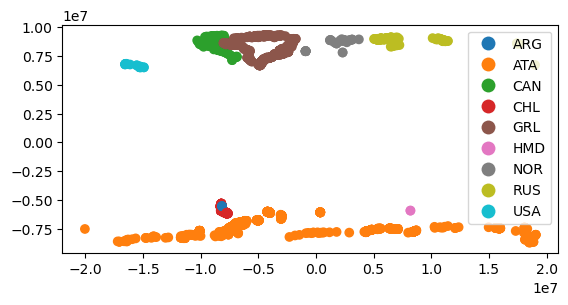

In [9]:
# this is only here for oggm, to assign all rgi-ids to a country,
# for provide we only assigned the common running glaciers (see above)
run_for_oggm = False
if run_for_oggm:
    # for oggm assign all rgi_ids to countries
    df_rgi_all = pd.read_csv(os.path.join(general_data_dir, 'rgi_position_terminus_backdrop_centroid.csv'),
                             index_col=0)

    df_rgi_all['geometry'] = df_rgi_all.apply(lambda row: Point(row['position_lon'], row['position_lat']),
                                              axis=1)
    gdf_rgi_ids_all = gpd.GeoDataFrame(df_rgi_all, geometry='geometry', crs='EPSG:4326')

    dict_country_to_rgi_ids_all = assign_rgi_ids_to_target_shapes(gdf_rgi_ids_all,
                                gdf_countries,
                                name_col_countries,
                                do_plot=True)
    with open(os.path.join(countries_data_dir,
                           "dict_country_to_all_rgi_ids_terminus.json"), "w") as outfile:
        json.dump(dict_country_to_rgi_ids_all, outfile)